In [1]:
import os
from IPython.display import Image
cwd =  os.getcwd().replace("notebooks/medium_articles","")
os.chdir(cwd)

### Setup test LP using UniswapPy

In [2]:
from uniswappy.cpt.quote import LPQuote
from uniswappy.cpt.factory import UniswapFactory
from uniswappy.erc import ERC20
from uniswappy.utils.data import UniswapExchangeData

user_nm = 'user_test'
eth_amount = 1000
dai_amount = 1000000

dai = ERC20("DAI", "0x111")
eth = ERC20("ETH", "0x09")
exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = dai, symbol="LP", address="0x011")

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)
lp.add_liquidity(user_nm, eth_amount, dai_amount, eth_amount, dai_amount)
lp.summary()

Exchange ETH-DAI (LP)
Reserves: ETH = 1000, DAI = 1000000
Liquidity: 31622.776601683792 



### Indexing problem
* We have some liquidity token (dL), and want to know home much x or y its worth
* Let's start with the **Naive approach** 

> $x = \frac{L^2}{y}$

> $\frac{dx}{dL} = \frac{2L}{y}$  

Substitute ($y = \frac{L^2}{x}$) into above

> $\frac{dx}{dL} = \frac{2x}{L}$ 

Hence $\Delta x $ approximates to:

> $\Delta x \sim \frac{2x \Delta L }{L}$ 

Likewise $\Delta L$ approximates to:

> $\Delta L \sim \frac{L \Delta x }{2x}$ 

Logically, this works ok for small values of $\Delta x$ and $\Delta L$, so let's assume $\Delta L$ is 1% of total supply 

In [3]:
lp_position = 0.01*lp.total_supply
naive_approximation = 2*lp.get_reserve(eth)*lp_position/(lp.total_supply)

print(f'{lp_position:.5f} LP token is worth {naive_approximation:.5f} ETH tokens using the Naive \napproach with 1% of LP')

316.22777 LP token is worth 20.00000 ETH tokens using the Naive 
approach with 1% of LP


However, not for large values; let's assume $\Delta L$ is 100% of total supply 

In [4]:
lp_position = lp.total_supply
naive_approximation = 2*lp.get_reserve(eth)*lp_position/(lp.total_supply)

print(f'{lp_position:.5f} LP token is worth {naive_approximation:.5f} ETH tokens using the Naive approach with 100% of LP')

31622.77660 LP token is worth 2000.00000 ETH tokens using the Naive approach with 100% of LP


2000 ETH is completely off, as there are only 1000 ETH in the pool!

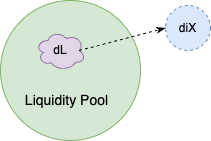

In [5]:
Image("doc/indexing_problem/indexed_tkn.png", width = 300, height = 300)

Given the definition of **_constant product trading_** (CPT) as:

> $(x-\Delta x)(y - \gamma\Delta y) = L^2$

where 
* $x$ -> reserve0 (r0)
* $y$ -> reserve1 (r1)
* $\Delta x$ -> swap x (a0)
* $\Delta y$ -> swap y (a1)
* $L$ -> total supply
* $\gamma$ -> fee $\left(ie, \frac{997}{1000} \right)$

We define the **_indexing problem_** via the following linear system of equations:

> (Eq. 1) $\Delta x = \frac{\Delta L x}{L}$

> (Eq. 2) $\Delta y  = \frac{\Delta L  y}{L}$

> (Eq. 3) $\Delta y_{(i)} = \Delta y  + \frac{\gamma \Delta x(y-\Delta y)}{(x - \Delta x) + \gamma \Delta x}$

where 
* $\Delta y_{(i)}$ -> indexed token
* $\Delta L$ -> liquidity deposit

In [6]:
def calc_tkn_settlement(lp, token_in, dL):

    if(token_in.token_name == lp.token1):
        x = lp.reserve0
        y = lp.reserve1
    else: 
        x = lp.reserve1
        y = lp.reserve0

    L = lp.total_supply
    a0 = dL*x/L
    a1 = dL*y/L
    gamma = 997/1000

    dy1 = a1
    dy2 = gamma*a0*(y - a1)/(x - a0 + gamma*a0)
    itkn_amt = dy1 + dy2

    return itkn_amt if itkn_amt > 0 else 0    

In [7]:
delta_L = 1
delta_eth = calc_tkn_settlement(lp, eth, delta_L)
delta_dai = calc_tkn_settlement(lp, dai, delta_L)
print(f'1 LP token is worth {delta_eth:.5f} {eth.token_name}')
print(f'1 LP token is worth {delta_dai:.5f} {dai.token_name}')

1 LP token is worth 0.06315 ETH
1 LP token is worth 63.14969 DAI


### Settlement problem
* We have x or y and want to know how much LP token it is worth

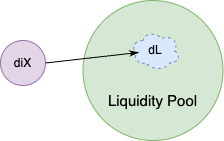

In [8]:
Image("doc/indexing_problem/settlement_lp_tkn.png", width = 300, height = 300)

Let's now address the problem; using the system of equations outlined in the **_indexing problem_**, Eq. 3 can be rearranged as:
> $(\Delta y_{(i)}x) - (\Delta y_{(i)}\Delta x) + (\gamma \Delta y_{(i)} \Delta x) - (\Delta y x) + (\Delta y\Delta x) - (\gamma y\Delta x) = 0$

Plug Eq. 1 and Eq. 2 into above, and we get:
> $(\Delta y_{(i)} x) - (\frac{\Delta y_{(i)} \Delta L x}{L}) + (\frac{\Delta y_{(i)} \gamma \Delta L x}{L}) - (\frac{\Delta L xy}{L}) + (\frac{\Delta L^2 xy}{L^2}) - (\frac{\Delta L \gamma x y}{L}) = 0$

The above equation gets reduced to the following quadratic:
> $\Delta L^2 \left( \frac{xy}{L^2} \right) - \Delta L \left(\frac{1000 \Delta y_{(i)} x - 997\Delta y_{(i)} x + 1000xy + 997 xy}{1000L} \right) + \Delta y_{(i)} x = 0$

#### Now, solve for $\Delta L$ using ```calc_lp_settlement``` 

In [9]:
import math

def calc_lp_settlement(lp, token_in, itkn_amt):

    if(token_in.token_name == lp.token1):
        x = lp.reserve0
        y = lp.reserve1
    else: 
        x = lp.reserve1
        y = lp.reserve0

    L = lp.total_supply
    gamma = 997

    a1 = x*y/L
    a2 = L
    a = a1/a2
    b = (1000*itkn_amt*x - itkn_amt*gamma*x + 1000*x*y + x*y*gamma)/(1000*L);
    c = itkn_amt*x;

    dL = (b*a2 - a2*math.sqrt(b*b - 4*a1*c/a2)) / (2*a1);
    return dL

In [10]:
print(f'{delta_eth:.5f} {eth.token_name} token is worth {calc_lp_settlement(lp, eth, delta_eth):.5f} LP tokens')
print(f'{delta_dai:.5f} {dai.token_name} token is worth {calc_lp_settlement(lp, dai, delta_dai):.5f} LP tokens')

0.06315 ETH token is worth 1.00000 LP tokens
63.14969 DAI token is worth 1.00000 LP tokens


## Using UniswapPy
* Use LPQuote and set quote_opposing = False

In [11]:
delta_eth = LPQuote(quote_opposing = False).get_amount_from_lp(lp, eth, 1)
delta_dai = LPQuote(quote_opposing = False).get_amount_from_lp(lp, dai, 1)
print(f'1 LP token is worth {delta_eth:.5f} {eth.token_name}')
print(f'1 LP token is worth {delta_dai:.5f} {dai.token_name}')

1 LP token is worth 0.06315 ETH
1 LP token is worth 63.14969 DAI


In [12]:
delta_eth_lp = LPQuote(quote_opposing = False).get_lp_from_amount(lp, eth, delta_eth)
delta_dai_lp = LPQuote(quote_opposing = False).get_lp_from_amount(lp, dai, delta_dai)
print(f'{delta_eth:.5f} {eth.token_name} token is worth {delta_eth_lp:.5f} LP tokens')
print(f'{delta_dai:.5f} {dai.token_name} token is worth {delta_dai_lp:.5f} LP tokens')

0.06315 ETH token is worth 1.00000 LP tokens
63.14969 DAI token is worth 1.00000 LP tokens


As we can see this quoting mechanisim is validated as we get back to the original 1 LP token for both assets

####  Finally, let's see how Indexed approach sizes up against the Naive approach

In [13]:
lp_position = 0.01*lp.total_supply
naive_approximation = 2*lp.get_reserve(eth)*lp_position/(lp.total_supply)
indexed_approach = LPQuote(quote_opposing = False).get_amount_from_lp(lp, eth, lp_position)

print(f'{lp_position:.2f} LP token is worth {naive_approximation:.2f} ETH tokens using the Naive approach with 1% of LP')
print(f'{lp_position:.2f} LP token is worth {indexed_approach:.2f} ETH tokens using the Indexed approach with 1% of LP')

316.23 LP token is worth 20.00 ETH tokens using the Naive approach with 1% of LP
316.23 LP token is worth 19.87 ETH tokens using the Indexed approach with 1% of LP


#### We can see that the Naive approximation is pretty close to our Indexed solution (with 1% LP); let's now try 100%

In [14]:
lp_position = lp.total_supply
naive_approximation = 2*lp.get_reserve(eth)*lp_position/(lp.total_supply)
indexed_approach = LPQuote(quote_opposing = False).get_amount_from_lp(lp, eth, lp_position)

print(f'{lp_position:.2f} LP token is worth {naive_approximation:.2f} ETH tokens using the Naive approach with 100% of LP')
print(f'{lp_position:.2f} LP token is worth {indexed_approach:.2f} ETH tokens using the Indexed approach with 100% of LP')

31622.78 LP token is worth 2000.00 ETH tokens using the Naive approach with 100% of LP
31622.78 LP token is worth 1000.00 ETH tokens using the Indexed approach with 100% of LP


#### Excellent, we see that with our Indexed solution all 1000 ETH are accounted for using the indexed approach

In [15]:
dai = ERC20("DAI", "0x111")
eth = ERC20("ETH", "0x09")
exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = dai, symbol="LP", address="0x011")

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)
lp.add_liquidity(user_nm, eth_amount, dai_amount, eth_amount, dai_amount)
lp.summary()

Exchange ETH-DAI (LP)
Reserves: ETH = 1000, DAI = 1000000
Liquidity: 31622.776601683792 



In [16]:
delta_dai_lp = LPQuote(quote_opposing = False).get_lp_from_amount(lp, dai, 1)
delta_dai_lp

0.01583514496167512